In [102]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv', index_col= ['id'])
test = pd.read_csv('test.csv', index_col= ['id'])

def drop(df): 
    for_dropping = ['Surname','CustomerId'] #Take CustomerId out to see the analysis of recurring CustomerIds
    df = df.drop(for_dropping, axis = 1)
    return df
train, test = drop(train), drop(test)

from sklearn.preprocessing import LabelEncoder
def encode_categories(df): 
    encoder = LabelEncoder()
    columns_for_encoding = ['Geography','Gender']
    for col in columns_for_encoding: 
        df[col] = encoder.fit_transform(df[col])
    return df
train, test = encode_categories(train), encode_categories(test)

In [103]:
train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,
0,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0


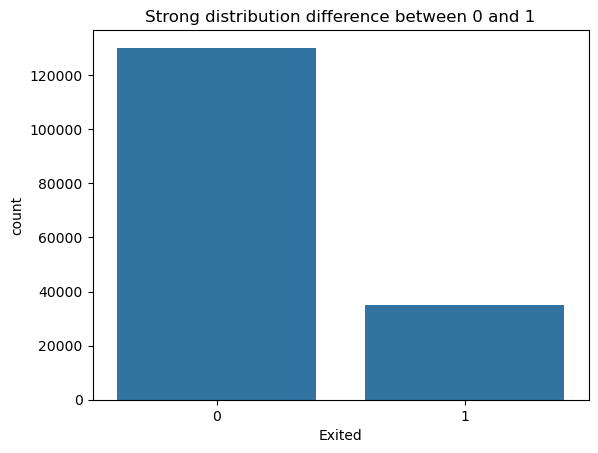

In [3]:
sns.countplot(x = train.Exited).set_title('Strong distribution difference between 0 and 1')
plt.show()

print('--- INVESTIGATING CUSTOMER IDS ---\n')

print(f'Unique customer IDs:                {train.CustomerId.nunique()}')
print(f'Number of rows in the train df:     {train.shape[0]}\n')

recurring_customer_ids = train['CustomerId'].value_counts()
recurring_customer_ids = recurring_customer_ids[recurring_customer_ids > 1]
recurring_customer_rows = train[train['CustomerId'].isin(recurring_customer_ids.index)]

recurring_customer_corr = recurring_customer_rows.corr(numeric_only=True)['Exited'].sort_values(ascending=False)
full_dataset_corr = train.corr(numeric_only=True)['Exited'].sort_values(ascending=False)

print(f'--- CORRELATION COMPARISON OF THE TARGET FEATURE ---\n{pd.DataFrame({
    'Recurring Customer Rows': recurring_customer_corr,
    'Full Dataset': full_dataset_corr
})}')

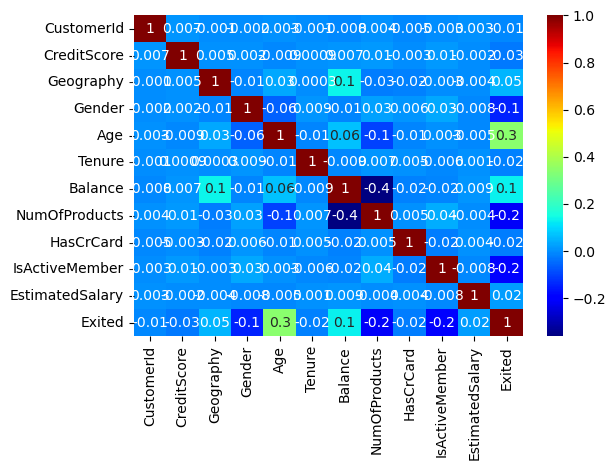

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,
0,15674932,668,0,1,33.0,3,0.0,2,1.0,0.0,181449.97,0


In [5]:
sns.heatmap(train.corr(numeric_only= True), annot = True, fmt= '.1g', cmap = 'jet')
plt.tight_layout()
plt.show()
display(train.head(1))

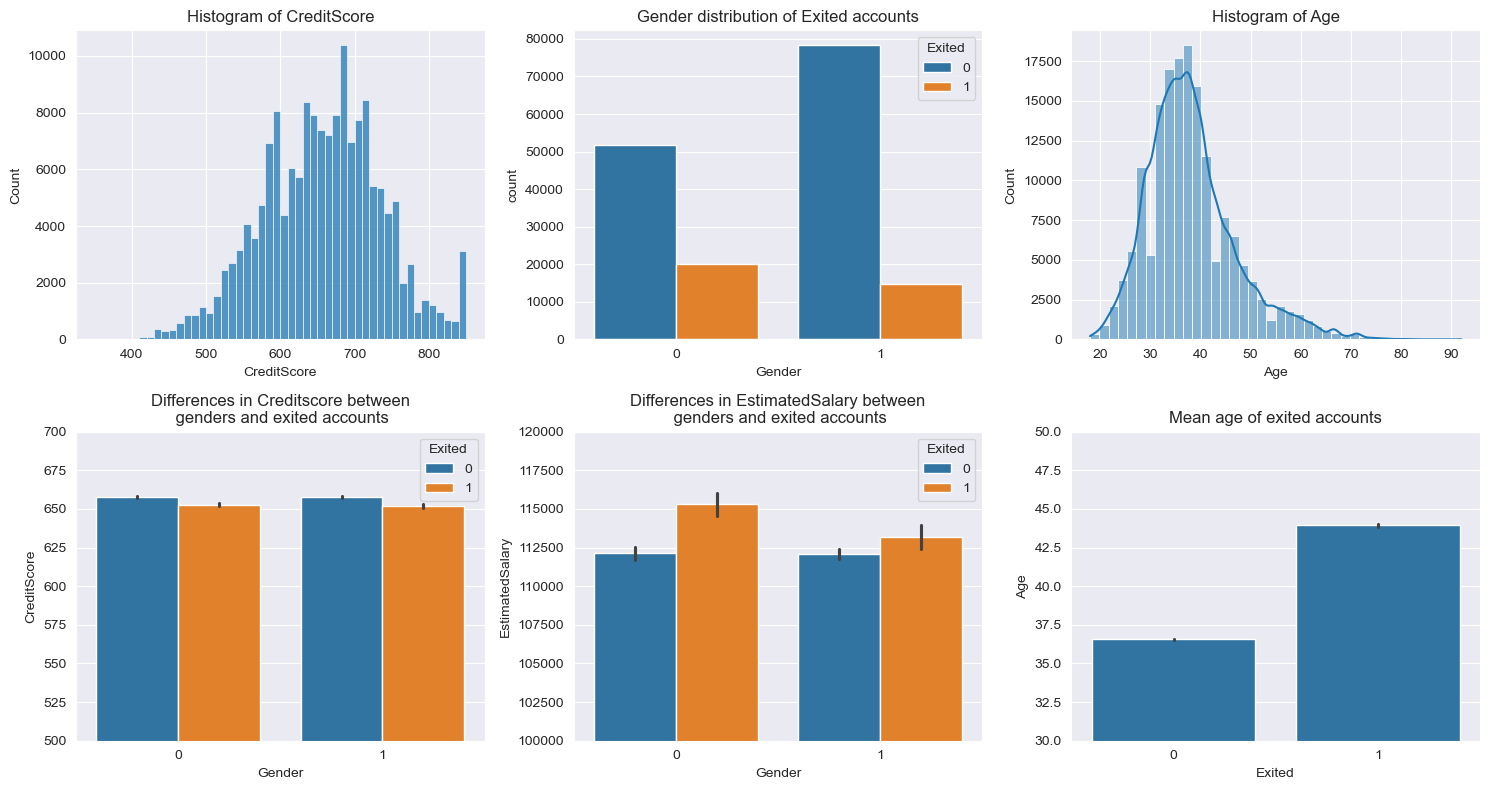

In [6]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(2, 3, figsize = (15, 8))

sns.histplot(train.CreditScore, bins = 50, ax = ax[0,0]).set_title('Histogram of CreditScore')
sns.barplot(x = train.Gender, y = train.CreditScore,  ax = ax[1,0], hue = train.Exited, estimator= np.mean, errorbar= 'ci').set_ylim(500, 700)
ax[1, 0].set_title('Differences in Creditscore between\n genders and exited accounts')

sns.countplot(x = train.Gender, ax= ax[0,1], hue = train.Exited).set_title('Gender distribution of Exited accounts')
sns.histplot(train.Age, ax = ax[0, 2], bins = 40, kde = True).set_title('Histogram of Age')

sns.barplot(x = train.Gender, y = train.EstimatedSalary, hue = train.Exited, ax = ax[1, 1], errorbar = 'ci', estimator = np.mean).set_ylim(100000, 120000)
ax[1, 1].set_title('Differences in EstimatedSalary between\n genders and exited accounts')
sns.barplot(x = train.Exited, y = train.Age, ax = ax[1, 2], errorbar= 'ci').set_ylim(30, 50)
ax[1, 2].set_title('Mean age of exited accounts')

plt.tight_layout()
plt.show()

In [104]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
scaler = MinMaxScaler(feature_range= (-1, 1)) 

X = train.copy().drop(['Exited'], axis =1 )
X = scaler.fit_transform(X)
y = train['Exited'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2, shuffle= True, random_state= 1)

In [8]:
#CLASSIFIER SELECTION

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

classifiers = [LogisticRegression(random_state= 1), 
               SGDClassifier(random_state= 1), SVC(random_state= 1, probability= True), 
               AdaBoostClassifier(algorithm= 'SAMME', random_state= 1),
               RandomForestClassifier(random_state= 1), 
               GradientBoostingClassifier(random_state= 1),
               KNeighborsClassifier(),
               MLPClassifier(max_iter= 1000, random_state= 1), 
               DecisionTreeClassifier(random_state= 1)
]

print('--- CLASSIFIER ROC AUC SCORE ---')
classifier_dict = dict()
for clf in classifiers: 
    clf_name = clf.__class__.__name__
    try:
        clf.fit(X_train, y_train)
        if hasattr(clf, "predict_proba"): 
            y_val_prob = clf.predict_proba(X_val)[:, 1]
        else:
            y_val_prob = clf.decision_function(X_val)
        
        score = round(roc_auc_score(y_val, y_val_prob), 4)
        classifier_dict[clf_name] = score
    except Exception as e:
        print(f"Failed to train {clf_name}: {e}")

score_df = pd.DataFrame(list(classifier_dict.items()), columns=['Classifier', 'ROC AUC']).sort_values(by='ROC AUC', ascending=False)
score_df

--- CLASSIFIER ROC AUC SCORE ---


,Classifier,ROC AUC
5,GradientBoostingClassifier,0.8861
7,MLPClassifier,0.8859
4,RandomForestClassifier,0.8724
3,AdaBoostClassifier,0.8710
2,SVC,0.8313
6,KNeighborsClassifier,0.8204
0,LogisticRegression,0.8104
1,SGDClassifier,0.8068
8,DecisionTreeClassifier,0.7060


In [124]:
#XGBOOST SINCE GRADIENTBOOSTING DID THE BEST

import xgboost as xgb

clf = xgb.XGBClassifier(random_state = 1,  
                        eval_metric = 'auc'
)

try: 
    clf.fit(X_train, y_train)
    pred = clf.predict(X_val)
    print(f'ROC-AUC SCORE: {roc_auc_score(pred, y_val)}')
except ValueError as e: 
   print(e)


ROC-AUC SCORE: 0.8112135903413892


In [125]:
test_scaled = scaler.fit_transform(test)
final_pred = clf.predict(test_scaled)
final_pred_df = pd.DataFrame(final_pred, index = test.index, columns = ['Exited'])
final_pred_df.to_csv('xgb_prediction_v3.csv')